In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_vit.vit import ViT_B32
import numpy as np
import pandas as pd
import os
import cv2
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.optimizers import SGD
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, MultiHeadAttention, Reshape
from tensorflow.keras.models import Model
import os
from tensorflow.keras.callbacks import TensorBoard

2023-12-09 11:44:59.039827: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# 读取位于指定路径的 CSV 文件并将其存储到 DataFrame 中
df_train = pd.read_csv("plant_dataset_org/train/train_label.csv")

# 对 DataFrame 的 "labels" 列应用 lambda 函数
# lambda 函数根据空格拆分 "labels" 列的值，并创建一个列表
df_train["labels"]=df_train["labels"].apply(lambda x:x.split(" ")) 

# 读取位于指定路径的 CSV 文件并将其存储到 DataFrame 中
df_val = pd.read_csv("plant_dataset_org/val/val_label.csv")
# 对 DataFrame 的 "labels" 列应用 lambda 函数
# lambda 函数根据空格拆分 "labels" 列的值，并创建一个列表
df_val["labels"]=df_val["labels"].apply(lambda x:x.split(" ")) 


# 指定包含训练图像和验证图像的目录路径
train_path='plant_dataset_org/train/images'
val_path = 'plant_dataset_org/val/images'


In [3]:
# 设置图像大小
img_size=(224,224)

# 创建图像数据生成器，用于数据增强
datagen = ImageDataGenerator(
    rescale=1./255,  # 对图像进行归一化，将像素缩放到[0,1]区间
    zoom_range=0.2,  # 随机缩放图像的范围
    horizontal_flip=True # 随机水平翻转图像
)

# 通过图像数据生成器创建训练数据生成器
train_generator=datagen.flow_from_dataframe(
dataframe=df_train, # 从 DataFrame_train 作为训练数据
directory=train_path, # 图像文件所在的目录路径
x_col="images", # DataFrame 中包含图像文件名的列
y_col="labels", # DataFrame 中包含标签的列
batch_size=4,  # 批处理大小
seed=42,  # 随机种子，确保可重复性
shuffle=True, # 每个 epoch 后打乱数据
class_mode="categorical",  # 返回 one-hot 编码的标签，适用于多分类问题
target_size=img_size)  # 图像目标大小

# 通过图像数据生成器创建验证数据生成器
val_generator=datagen.flow_from_dataframe(
dataframe=df_val,  # 从 DataFrame_val作为验证数据
directory=val_path,
x_col="images",
y_col="labels",
batch_size=4,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=img_size)

print(train_generator.class_indices)
print(val_generator.class_indices)


Found 3000 validated image filenames belonging to 6 classes.
Found 600 validated image filenames belonging to 6 classes.
{'complex': 0, 'frog_eye_leaf_spot': 1, 'healthy': 2, 'powdery_mildew': 3, 'rust': 4, 'scab': 5}
{'complex': 0, 'frog_eye_leaf_spot': 1, 'healthy': 2, 'powdery_mildew': 3, 'rust': 4, 'scab': 5}


In [10]:
# 设置参数
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 6
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 150
# 计算学习率衰减的速率，即每个epoch衰减的学习率
decay_rate=LEARNING_RATE/EPOCHS
# 设置动量参数
momentum=0.8
# 使用随机梯度下降SGD优化器，设置学习率、动量和学习率衰减
sgd=SGD(learning_rate=LEARNING_RATE,momentum=momentum,decay=decay_rate)

In [11]:
# 构建 ViT 模型
model = ViT_B32(
    image_size=IMAGE_SIZE,
    num_classes=NUM_CLASSES,
    activation='sigmoid'  # 激活函数可以根据具体任务进行选择
)


In [12]:
model.summary()

Model: "ViT-B-32-224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_embedding (PatchEmbed  (None, 49, 768)          2360064   
 ding)                                                           
                                                                 
 add_cls_token (AddCLSToken)  (None, 50, 768)          768       
                                                                 
 position_embedding (AddPosi  (None, 50, 768)          38400     
 tionEmbedding)                                                  
                                                                 
 transformer_block_0 (Transf  (None, 50, 768)          7087872   
 ormerEncoder)                                                   
                                                                 
 transformer_block_1 (Transf  (None, 50, 768)          7087872   
 ormerEncoder)                                        

In [13]:
# 编译模型
model.compile(
    optimizer='sgd',loss='binary_crossentropy',metrics=[tf.keras.metrics.Precision()])

In [14]:
# Early stopping callback
# 创建EarlyStopping回调函数，用于在训练过程中根据验证集损失来提前停止训练
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

In [15]:
# 训练模型
model_history = model.fit(
    x=train_generator,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[callback,TensorBoard(log_dir="MyBoard_VIT",histogram_freq=0)]
)

# 关机
#os.system("shutdown")

Epoch 1/150
93/93 [==============================] - 43s 298ms/step - loss: 0.4964 - precision_1: 0.2968 - val_loss: 0.4393 - val_precision_1: 0.7273
Epoch 2/150
93/93 [==============================] - 26s 277ms/step - loss: 0.4601 - precision_1: 0.3525 - val_loss: 0.4575 - val_precision_1: 0.3171
Epoch 3/150
93/93 [==============================] - 26s 279ms/step - loss: 0.4377 - precision_1: 0.3482 - val_loss: 0.4365 - val_precision_1: 0.4762
Epoch 4/150
93/93 [==============================] - 25s 272ms/step - loss: 0.4521 - precision_1: 0.4545 - val_loss: 0.4513 - val_precision_1: 0.4318
Epoch 5/150
93/93 [==============================] - 26s 274ms/step - loss: 0.4410 - precision_1: 0.4205 - val_loss: 0.3804 - val_precision_1: 0.6000
Epoch 6/150
93/93 [==============================] - 25s 271ms/step - loss: 0.4308 - precision_1: 0.4234 - val_loss: 0.4644 - val_precision_1: 0.4091
Epoch 7/150
93/93 [==============================] - 25s 274ms/step - loss: 0.4535 - precision_1: 0.

In [16]:
# 在模型训练后保存整个模型
model.save("Final_VIT", save_format='tf')

INFO:tensorflow:Assets written to: Final_VIT/assets


INFO:tensorflow:Assets written to: Final_VIT/assets


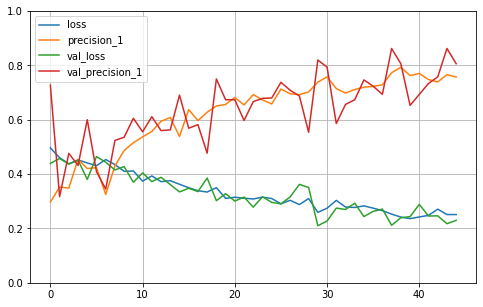

In [17]:
# plotting the varoius metrics
# 将模型训练的历史记录转换为 DataFrame，并绘制各种指标的曲线图
pd.DataFrame(model_history.history).plot(figsize=(8,5))

# 设置绘图区域的网格
plt.grid(True)

# 设置y轴的取值范围在0到1之间，以便更好地观察精确度等指标
plt.gca().set_ylim(0,1)

# 显示绘图
plt.show()

In [18]:
# 加载整个模型
loaded_model = keras.models.load_model("Final_VIT")

# 指定测试图像文件夹的路径
test_path = 'plant_dataset_org/test/images'
# 读取位于指定路径的 CSV 文件并将其存储到 DataFrame 中
df_test = pd.read_csv("plant_dataset_org/test/test_label.csv")
# 对 DataFrame 的 "labels" 列应用 lambda 函数
# lambda 函数根据空格拆分 "labels" 列的值，并创建一个列表
df_test["labels"]=df_test["labels"].apply(lambda x:x.split(" ")) 
# 通过图像数据生成器创建测试数据生成器

test_generator = datagen.flow_from_dataframe(
    dataframe=df_test,            # 包含图像文件名的 DataFrame
    directory=test_path,              # 测试图像文件夹的路径
    x_col="images",                    # DataFrame 中包含图像文件名的列
    y_col="labels",                    # 在测试阶段不需要标签
    batch_size=1,                     # 批处理大小为1，因为每个测试样本都是单独的批次
    seed=42,                          # 随机种子，确保可重复性
    shuffle=False,                     # 每次生成数据时是否打乱数据
    class_mode="categorical",         # 在测试阶段需要类别信息
    target_size=img_size              # 图像目标大小
)



Found 600 validated image filenames belonging to 6 classes.


In [19]:
# 在测试集上评估模型
evaluation = loaded_model.evaluate(test_generator, steps=test_generator.samples // 1)
print("Test Accuracy: {:.2f}%".format(evaluation[1] * 100))

600/600 [==============================] - 40s 65ms/step - loss: 0.2565 - precision_1: 0.7528
Test Accuracy: 75.28%


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 获取测试集的真实标签
true_labels = np.concatenate([test_generator[i][1] for i in range(len(test_generator))])
# print(true_labels)
# 获取模型在测试集上的预测标签
predicted_labels = loaded_model.predict(test_generator, steps=len(test_generator))
# 将标签从 one-hot 编码转换为类别
true_classes = np.argmax(true_labels, axis=1)
predicted_classes = np.argmax(predicted_labels, axis=1)

# 计算混淆矩阵
cm = confusion_matrix(true_classes, predicted_classes)

# 可视化混淆矩阵
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_VIT.png')
plt.show()

410/600 [===================>..........] - ETA: 11s